In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from prophet import Prophet
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import os
from datetime import datetime
from scipy import stats

# Set random seeds for reproducibility
def set_seeds(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    
set_seeds()

## Data Loading and Preprocessing

In [2]:
def load_data(file_path):
    """Load data from parquet file."""
    return pd.read_parquet(file_path)

def split_data(data, train_years, val_year, test_year):
    """Split data into train, validation and test sets based on years."""
    data['time_bucket'] = pd.to_datetime(data['time_bucket'])
    
    train_data = data[data['time_bucket'].dt.year.isin(train_years)]
    val_data = data[data['time_bucket'].dt.year == val_year]
    test_data = data[data['time_bucket'].dt.year == test_year]
    
    print(f"Train data size: {len(train_data)}")
    print(f"Validation data size: {len(val_data)}")
    print(f"Test data size: {len(test_data)}")
    
    return train_data, val_data, test_data

def filter_ride_data(data, ride_name):
    """Filter data for a specific ride."""
    return data[data[f'ride_name_{ride_name}'] == True].copy()

In [3]:
# Load the data
data = load_data("../data/processed/ep/final_cleaned_processed_wait_times.parquet")
data

,wait_time,closed,temperature,rain,wind,is_german_holiday,is_swiss_holiday,is_french_holiday,time_bucket,day_of_week,...,season_summer,season_winter,year_2017,year_2018,year_2019,year_2020,year_2021,year_2022,year_2023,year_2024
0,0.0,0,0.043878,-0.283247,-0.987521,0,0,0,2017-05-23 09:00:00,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0,0.043878,-0.283247,-0.987521,0,0,0,2017-05-23 09:00:00,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0,0.043878,-0.283247,-0.987521,0,0,0,2017-05-23 09:00:00,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0,0.043878,-0.283247,-0.987521,0,0,0,2017-05-23 09:00:00,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0,0.043878,-0.283247,-0.987521,0,0,0,2017-05-23 09:00:00,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
904291,20.0,0,-2.523810,-0.283247,-0.696543,0,0,0,2024-12-31 17:30:00,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
904292,20.0,0,-2.523810,-0.283247,-0.696543,0,0,0,2024-12-31 17:30:00,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
904293,5.0,0,-2.523810,-0.283247,-0.696543,0,0,0,2024-12-31 17:30:00,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
904294,0.0,0,-2.523810,-0.283247,-0.696543,0,0,0,2024-12-31 17:30:00,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [4]:
# Define time periods for splitting
train_years, val_year, test_year = list(range(2017, 2023)), 2023, 2024

# Split the data
train_data, val_data, test_data = split_data(data, train_years, val_year, test_year)

Train data size: 663140
Validation data size: 126983
Test data size: 114173


In [5]:
# Filter for a specific ride
ride_name = "silver star"
ride_data = filter_ride_data(train_data, ride_name)
ride_data

,wait_time,closed,temperature,rain,wind,is_german_holiday,is_swiss_holiday,is_french_holiday,time_bucket,day_of_week,...,season_summer,season_winter,year_2017,year_2018,year_2019,year_2020,year_2021,year_2022,year_2023,year_2024
2,0.0,0,0.043878,-0.283247,-0.987521,0,0,0,2017-05-23 09:00:00,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,10.0,0,0.043878,-0.283247,-0.987521,0,0,0,2017-05-23 09:30:00,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47,10.0,0,0.424277,-0.283247,-1.220303,0,0,0,2017-05-23 10:00:00,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71,25.0,0,0.424277,-0.283247,-1.220303,0,0,0,2017-05-23 10:30:00,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
94,15.0,0,0.736746,-0.283247,-0.580151,0,0,0,2017-05-23 11:00:00,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662949,25.0,0,0.084635,-0.249987,1.107521,0,0,0,2022-12-31 14:30:00,5,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
662986,25.0,0,0.057464,-0.249987,0.932935,0,0,0,2022-12-31 15:00:00,5,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
663005,25.0,0,0.057464,-0.249987,0.932935,0,0,0,2022-12-31 15:30:00,5,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
663087,35.0,0,-0.214249,-0.216727,0.991130,0,0,0,2022-12-31 17:00:00,5,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Time Series Decomposition with Prophet

In [6]:
class ProphetTimeSeriesModel:
    """Class to handle Prophet time series modeling."""
    
    def __init__(self):
        self.model = None
        self.forecast = None
        
    def prepare_prophet_dataframe(self, data):
        """Prepare data for Prophet."""
        prophet_df = data[['time_bucket', 'wait_time', 
                          "is_german_holiday", "is_swiss_holiday", "is_french_holiday"]].copy()
        prophet_df = prophet_df.rename(columns={'time_bucket': 'ds', 'wait_time': 'y'})
        return prophet_df
    
    def prepare_holidays(self, prophet_df):
        """Prepare holiday dataframe for Prophet."""
        holiday_cols = ['is_german_holiday', 'is_swiss_holiday', 'is_french_holiday']
        holidays_df = []
        
        for col in holiday_cols:
            holiday_dates = prophet_df[prophet_df[col] > 0]['ds'].dt.date.unique()
            holiday_name = col.replace('is_', '').replace('_holiday', '')
            if len(holiday_dates) > 0:
                holidays_df.append(pd.DataFrame({
                    'holiday': holiday_name,
                    'ds': pd.to_datetime(holiday_dates),
                    'lower_window': 0,
                    'upper_window': 0
                }))
        
        if holidays_df:
            holidays = pd.concat(holidays_df, ignore_index=True)
            holidays = holidays.sort_values(by='ds')
            return holidays
        
        return None
    
    def fit(self, prophet_df):
        """Fit the Prophet model."""
        holidays = self.prepare_holidays(prophet_df)
        
        self.model = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=True,
            holidays=holidays,
            interval_width=0.95
        )
        
        self.model.fit(prophet_df)
        return self.model
    
    def predict(self, future_df):
        """Generate predictions with the fitted model."""
        self.forecast = self.model.predict(future_df)
        return self.forecast
    
    def merge_predictions(self, original_data, forecast_data):
        """Merge original data with forecasts and calculate residuals."""
        result = original_data.copy()
        forecast_columns = ['ds', 'trend', 'yearly', 'weekly', 'daily', 'yhat']
        
        result = pd.merge(
            result, 
            forecast_data[forecast_columns], 
            left_on='time_bucket', 
            right_on='ds', 
            how='left'
        )
        
        result['residual'] = result['wait_time'] - result['yhat']
        return result

In [7]:
# Initialize Prophet model
prophet_ts = ProphetTimeSeriesModel()

# Prepare data for Prophet
prophet_df = prophet_ts.prepare_prophet_dataframe(ride_data)
prophet_df

,ds,y,is_german_holiday,is_swiss_holiday,is_french_holiday
2,2017-05-23 09:00:00,0.0,0,0,0
24,2017-05-23 09:30:00,10.0,0,0,0
47,2017-05-23 10:00:00,10.0,0,0,0
71,2017-05-23 10:30:00,25.0,0,0,0
94,2017-05-23 11:00:00,15.0,0,0,0
...,...,...,...,...,...
662949,2022-12-31 14:30:00,25.0,0,0,0
662986,2022-12-31 15:00:00,25.0,0,0,0
663005,2022-12-31 15:30:00,25.0,0,0,0
663087,2022-12-31 17:00:00,35.0,0,0,0


In [8]:
# Prepare holiday data
holidays = prophet_ts.prepare_holidays(prophet_df)
holidays

,holiday,ds,lower_window,upper_window
0,german,2017-05-25,0,0
44,swiss,2017-05-25,0,0
91,french,2017-05-25,0,0
92,french,2017-05-27,0,0
1,german,2017-06-05,0,0
...,...,...,...,...
88,swiss,2022-11-01,0,0
133,french,2022-11-11,0,0
89,swiss,2022-12-08,0,0
90,swiss,2022-12-26,0,0


In [9]:
# Fit Prophet model
prophet_model = prophet_ts.fit(prophet_df)

15:15:54 - cmdstanpy - INFO - Chain [1] start processing
15:16:10 - cmdstanpy - INFO - Chain [1] done processing


In [10]:
# Generate future dataframe for prediction
all_timestamps = ride_data['time_bucket'].unique()
future = pd.DataFrame(all_timestamps, columns=['ds'])
future

,ds
0,2017-05-23 09:00:00
1,2017-05-23 09:30:00
2,2017-05-23 10:00:00
3,2017-05-23 10:30:00
4,2017-05-23 11:00:00
...,...
21973,2022-12-31 14:30:00
21974,2022-12-31 15:00:00
21975,2022-12-31 15:30:00
21976,2022-12-31 17:00:00


In [11]:
# Make predictions
train_forecast = prophet_ts.predict(future)

In [12]:
# Merge predictions with original data
result = prophet_ts.merge_predictions(ride_data, train_forecast)
result

,wait_time,closed,temperature,rain,wind,is_german_holiday,is_swiss_holiday,is_french_holiday,time_bucket,day_of_week,...,year_2022,year_2023,year_2024,ds,trend,yearly,weekly,daily,yhat,residual
0,0.0,0,0.043878,-0.283247,-0.987521,0,0,0,2017-05-23 09:00:00,1,...,0.0,0.0,0.0,2017-05-23 09:00:00,-250.630500,36.885141,-0.536708,215.631587,1.349520,-1.349520
1,10.0,0,0.043878,-0.283247,-0.987521,0,0,0,2017-05-23 09:30:00,1,...,0.0,0.0,0.0,2017-05-23 09:30:00,-250.630573,36.888886,-0.651711,231.685606,17.292208,-7.292208
2,10.0,0,0.424277,-0.283247,-1.220303,0,0,0,2017-05-23 10:00:00,1,...,0.0,0.0,0.0,2017-05-23 10:00:00,-250.630646,36.892609,-0.771464,238.924406,24.414905,-14.414905
3,25.0,0,0.424277,-0.283247,-1.220303,0,0,0,2017-05-23 10:30:00,1,...,0.0,0.0,0.0,2017-05-23 10:30:00,-250.630719,36.896309,-0.895545,240.575172,25.945217,-0.945217
4,15.0,0,0.736746,-0.283247,-0.580151,0,0,0,2017-05-23 11:00:00,1,...,0.0,0.0,0.0,2017-05-23 11:00:00,-250.630792,36.899989,-1.023521,239.232267,24.477943,-9.477943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21973,25.0,0,0.084635,-0.249987,1.107521,0,0,0,2022-12-31 14:30:00,5,...,1.0,0.0,0.0,2022-12-31 14:30:00,-245.079973,38.096278,9.942810,229.904577,32.863692,-7.863692
21974,25.0,0,0.057464,-0.249987,0.932935,0,0,0,2022-12-31 15:00:00,5,...,1.0,0.0,0.0,2022-12-31 15:00:00,-245.079542,38.097575,10.013496,230.458945,33.490473,-8.490473
21975,25.0,0,0.057464,-0.249987,0.932935,0,0,0,2022-12-31 15:30:00,5,...,1.0,0.0,0.0,2022-12-31 15:30:00,-245.079112,38.098666,10.067881,231.182219,34.269655,-9.269655
21976,35.0,0,-0.214249,-0.216727,0.991130,0,0,0,2022-12-31 17:00:00,5,...,1.0,0.0,0.0,2022-12-31 17:00:00,-245.077821,38.100696,10.132485,233.040683,36.196044,-1.196044


## Visualization Utilities

In [13]:
def visualize_prophet_components(result_df, model, forecast, component_figsize=(12, 12), residual_figsize=(12, 6)):
    """
    Visualize Prophet components and residuals.
    
    Parameters:
    -----------
    result_df : pandas.DataFrame
        DataFrame containing the original data merged with forecasts
    model : Prophet
        Fitted Prophet model
    forecast : pandas.DataFrame
        Prophet forecast results
    component_figsize : tuple
        Figure size for components plot
    residual_figsize : tuple
        Figure size for residuals plot
    """
    # 1. Plot the Prophet components
    fig_comp = model.plot_components(forecast, figsize=component_figsize)
    plt.tight_layout()
    
    # 2. Plot the residuals
    fig_resid, ax = plt.subplots(figsize=residual_figsize)
    ax.scatter(result_df['ds'], result_df['residual'], alpha=0.5, s=10)
    ax.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    ax.set_title('Residuals')
    ax.set_xlabel('Date')
    ax.set_ylabel('Residual (minutes)')
    
    # Add a trend line to residuals
    z = np.polyfit(range(len(result_df)), result_df['residual'], 1)
    p = np.poly1d(z)
    ax.plot(result_df['ds'], p(range(len(result_df))), "r--", alpha=0.8)
    
    # 3. Plot residual distribution
    fig_dist, ax = plt.subplots(1, 2, figsize=residual_figsize)
    
    # Histogram
    ax[0].hist(result_df['residual'], bins=50, alpha=0.7)
    ax[0].set_title('Residual Distribution')
    ax[0].set_xlabel('Residual')
    ax[0].set_ylabel('Frequency')
    
    # QQ Plot for checking normality
    stats.probplot(result_df['residual'].dropna(), plot=ax[1])
    ax[1].set_title('Residual Q-Q Plot')
    
    plt.tight_layout()
    
    # 4. Plot actual vs predicted
    fig_pred, ax = plt.subplots(figsize=residual_figsize)
    ax.scatter(result_df['wait_time'], result_df['yhat'], alpha=0.5, s=10)
    
    # Add identity line (y=x)
    min_val = min(result_df['wait_time'].min(), result_df['yhat'].min())
    max_val = max(result_df['wait_time'].max(), result_df['yhat'].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--')
    
    ax.set_title('Actual vs Predicted')
    ax.set_xlabel('Actual Wait Time (minutes)')
    ax.set_ylabel('Predicted Wait Time (minutes)')
    
    return fig_comp, fig_resid, fig_dist, fig_pred

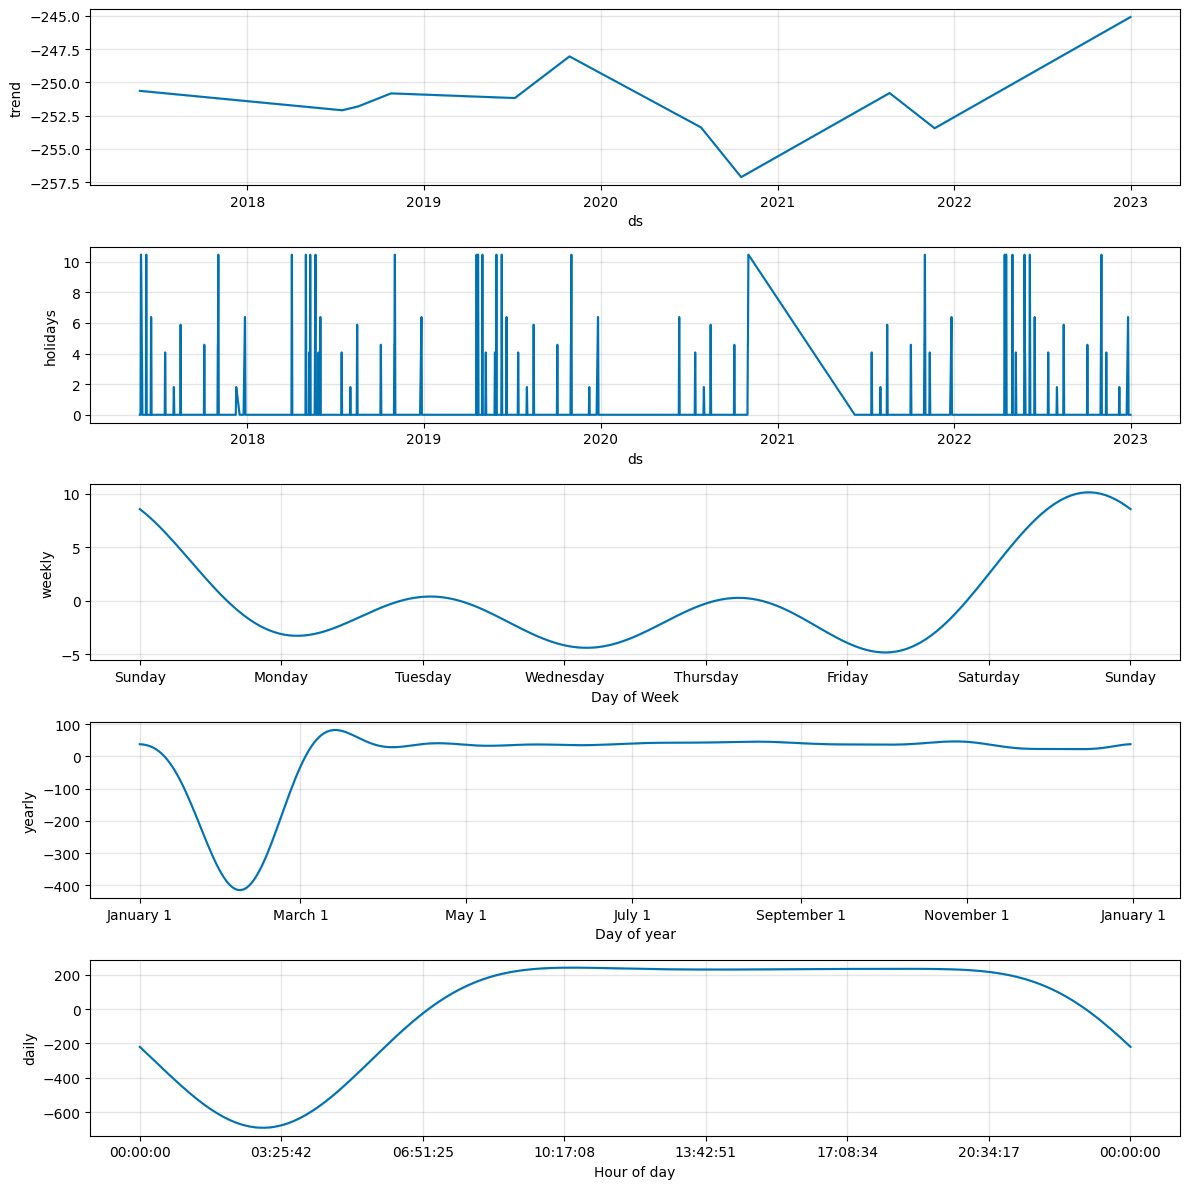

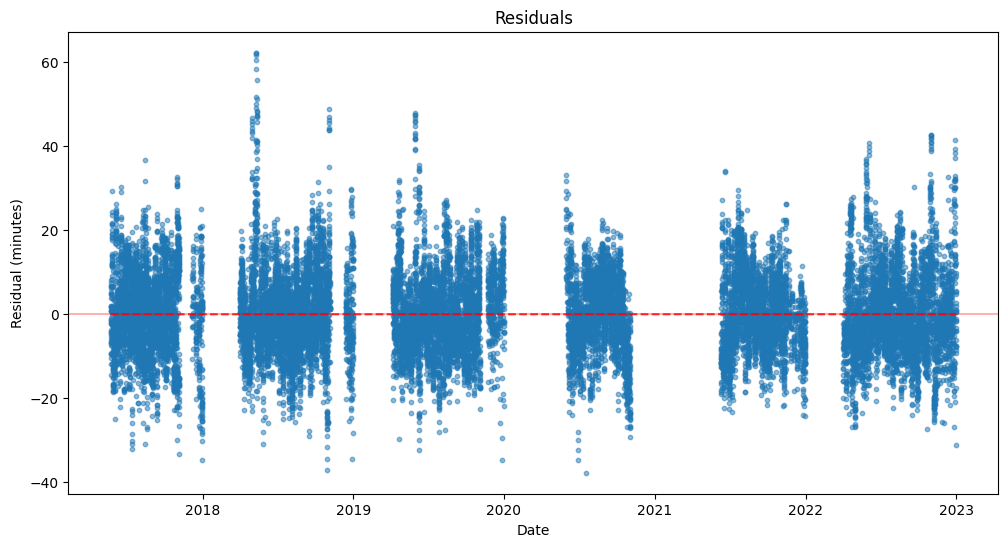

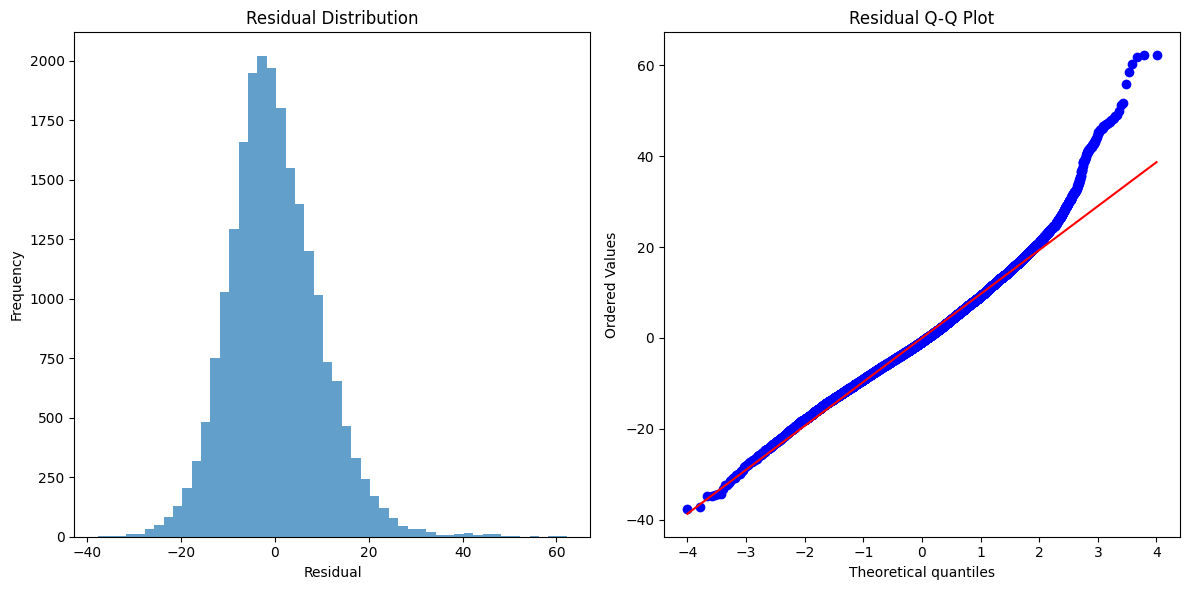

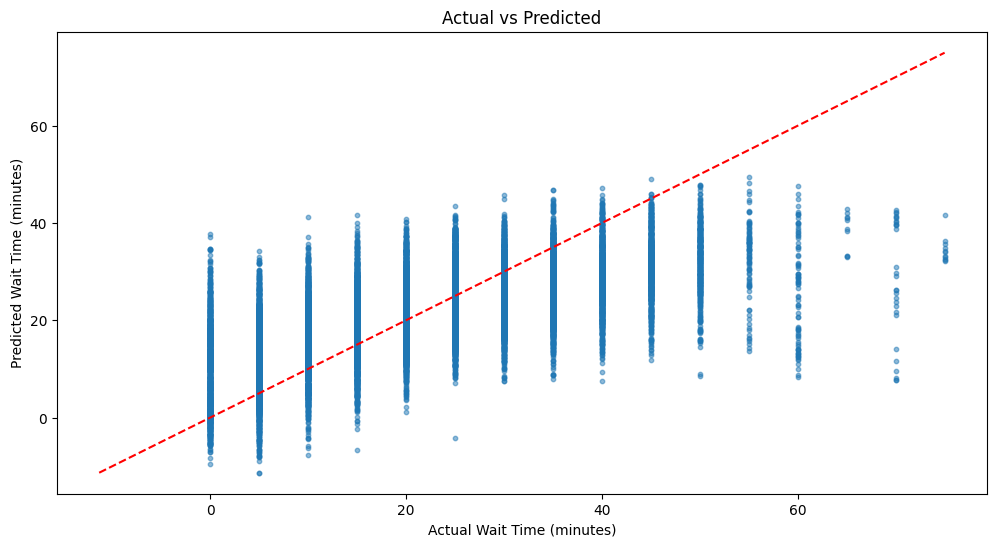

In [14]:
# Visualize Prophet components
fig_comp, fig_resid, fig_dist, fig_pred = visualize_prophet_components(
    result, prophet_model, train_forecast
)

# Display all figures
plt.show()

In [15]:
# Check for NaN values in forecast
train_forecast.isna().any().any()

np.False_

## Feature Engineering

In [16]:
class FeatureEngineer:
    """Class to handle feature engineering for the wait time prediction model."""
    
    @staticmethod
    def prepare_features(ride_data_df, forecast_df):
        """
        Prepare features for the neural network model.
        
        Parameters:
        -----------
        ride_data_df : pandas.DataFrame
            DataFrame containing ride data
        forecast_df : pandas.DataFrame
            DataFrame containing Prophet forecasts
            
        Returns:
        --------
        numpy.ndarray
            Array of features for the neural network
        """
        # Extract weather features
        weather_features = ride_data_df[['temperature', 'rain']].values
        
        # Extract holiday features
        holiday_features = ride_data_df[
            ['is_german_holiday', 'is_swiss_holiday', 'is_french_holiday']
        ].astype(float).values

        # Extract time features
        timestamps = forecast_df['ds']
        time_features = FeatureEngineer._create_cyclical_time_features(timestamps)

        # Combine all features
        features = np.hstack([weather_features, holiday_features, time_features])
        return features
    
    @staticmethod
    def _create_cyclical_time_features(timestamps):
        """
        Create cyclical time features from timestamps.
        
        Parameters:
        -----------
        timestamps : pandas.Series
            Series of timestamps
            
        Returns:
        --------
        numpy.ndarray
            Array of cyclical time features
        """
        # Extract time components
        hour = timestamps.dt.hour
        day_of_week = timestamps.dt.dayofweek
        month = timestamps.dt.month
        day_of_year = timestamps.dt.dayofyear

        # Create cyclical features
        hour_sin = np.sin(2 * np.pi * hour / 24)
        hour_cos = np.cos(2 * np.pi * hour / 24)
        dow_sin = np.sin(2 * np.pi * day_of_week / 7)
        dow_cos = np.cos(2 * np.pi * day_of_week / 7)
        month_sin = np.sin(2 * np.pi * month / 12)
        month_cos = np.cos(2 * np.pi * month / 12)
        doy_sin = np.sin(2 * np.pi * day_of_year / 365.25)
        doy_cos = np.cos(2 * np.pi * day_of_year / 365.25)

        # Stack all cyclical features
        cyclical_features = np.column_stack([
            hour_sin, hour_cos, 
            dow_sin, dow_cos,
            month_sin, month_cos,
            doy_sin, doy_cos
        ])
        
        return cyclical_features

In [17]:
# Prepare features for training
feature_engineer = FeatureEngineer()
train_features = feature_engineer.prepare_features(ride_data, train_forecast)
train_residuals = result['residual'].values

In [18]:
# Prepare validation data
ride_val_data = filter_ride_data(val_data, ride_name)
val_dates = pd.DataFrame({'ds': ride_val_data['time_bucket'].unique()})
val_forecast = prophet_ts.predict(val_dates)

# Merge validation data with forecasts
ride_val_data = pd.merge(
    ride_val_data, 
    val_forecast[['ds', 'yhat']], 
    left_on='time_bucket', 
    right_on='ds', 
    how='left'
)
ride_val_data['residual'] = ride_val_data['wait_time'] - ride_val_data['yhat']
ride_val_data

,wait_time,closed,temperature,rain,wind,is_german_holiday,is_swiss_holiday,is_french_holiday,time_bucket,day_of_week,...,year_2018,year_2019,year_2020,year_2021,year_2022,year_2023,year_2024,ds,yhat,residual
0,15.0,0,-1.301101,-0.283247,2.911586,0,0,0,2023-04-01 09:30:00,5,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2023-04-01 09:30:00,27.082852,-12.082852
1,30.0,0,-1.273930,0.714554,2.853390,0,0,0,2023-04-01 10:00:00,5,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2023-04-01 10:00:00,34.519407,-4.519407
2,25.0,0,-1.273930,0.714554,2.853390,0,0,0,2023-04-01 10:30:00,5,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2023-04-01 10:30:00,36.354908,-11.354908
3,25.0,0,-1.273930,0.714554,2.562412,0,0,0,2023-04-01 11:00:00,5,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2023-04-01 11:00:00,35.183245,-10.183245
4,20.0,0,-1.273930,0.714554,2.562412,0,0,0,2023-04-01 11:30:00,5,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2023-04-01 11:30:00,32.831031,-12.831031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4237,15.0,0,-0.893532,-0.283247,-0.871130,0,0,0,2023-12-30 15:30:00,5,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2023-12-30 15:30:00,41.388678,-26.388678
4238,20.0,0,-0.907117,-0.283247,0.118196,0,0,0,2023-12-30 16:00:00,5,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2023-12-30 16:00:00,42.180431,-22.180431
4239,25.0,0,-0.907117,-0.283247,0.118196,0,0,0,2023-12-30 16:30:00,5,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2023-12-30 16:30:00,42.851940,-17.851940
4240,30.0,0,-1.042974,-0.283247,-0.114587,0,0,0,2023-12-30 17:00:00,5,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2023-12-30 17:00:00,43.347918,-13.347918


In [19]:
# Prepare validation features
val_features = feature_engineer.prepare_features(ride_val_data, val_forecast)
val_residuals = ride_val_data['residual'].values

## Neural Network Model

In [20]:
class RideDataset(Dataset):
    """PyTorch Dataset for ride wait time data."""
    
    def __init__(self, features, targets):
        """
        Initialize the dataset.
        
        Parameters:
        -----------
        features : numpy.ndarray
            Array of features
        targets : numpy.ndarray
            Array of target values
        """
        self.features = torch.tensor(features, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32).reshape(-1, 1)
    
    def __len__(self):
        """Return the number of samples in the dataset."""
        return len(self.features)
    
    def __getitem__(self, idx):
        """Get a sample from the dataset."""
        # Handle NaN values
        features = np.nan_to_num(self.features[idx])
        targets = np.nan_to_num(self.targets[idx])

        return features, targets

In [27]:
class ResidualPredictor(nn.Module):
    """Neural network model for predicting residuals."""
    
    def __init__(self, input_dim, hidden_dims=[64, 32], dropout_prob=0.2):
        super(ResidualPredictor, self).__init__()
        
        layers = []
        
        # Input layer
        layers.append(nn.Linear(input_dim, hidden_dims[0]))
        layers.append(nn.BatchNorm1d(hidden_dims[0]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_prob))
        
        # Hidden layers
        for i in range(len(hidden_dims)-1):
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            layers.append(nn.BatchNorm1d(hidden_dims[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_prob))
            
        # Output layer
        layers.append(nn.Linear(hidden_dims[-1], 1))
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        """Forward pass through the model."""
        return self.model(x)

In [28]:
class ModelTrainer:
    """Class to handle model training and evaluation."""
        
    @staticmethod
    def train_nn_model(train_features, train_residuals, val_features, val_residuals, 
                    hidden_dims=[128, 64], dropout_prob=0.1, 
                    batch_size=512, patience=20, device='cpu'):
        """
        Train the neural network model.
        
        Parameters:
        -----------
        train_features : numpy.ndarray
            Training features
        train_residuals : numpy.ndarray
            Training targets (residuals)
        val_features : numpy.ndarray
            Validation features
        val_residuals : numpy.ndarray
            Validation targets (residuals)
        hidden_dims : list
            List of hidden layer dimensions
        dropout_prob : float
            Dropout probability
        batch_size : int
            Batch size for training
        patience : int
            Number of epochs to wait for improvement before early stopping
        device : str
            Device to use for training ('cpu' or 'cuda')
            
        Returns:
        --------
        ResidualPredictor
            Trained neural network model
        """
        # Create datasets and dataloaders
        train_dataset = RideDataset(train_features, train_residuals)
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        val_dataset = RideDataset(val_features, val_residuals)
        val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Initialize model
        input_dim = train_features.shape[1]
        model = ResidualPredictor(input_dim, hidden_dims=hidden_dims, dropout_prob=dropout_prob)
        model.to(device)

        # Loss function and optimizer
        criterion = nn.MSELoss()
        optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

        # Training loop parameters
        num_epochs = 200
        best_val_loss = float('inf')
        epochs_no_improve = 0
        best_model_state = None

        # Training loop with tqdm progress bar
        pbar = tqdm(range(num_epochs), desc="Training")
        for epoch in pbar:
            # Training phase
            model.train()
            running_loss = 0.0
            
            for batch_features, batch_residuals in train_dataloader:
                batch_features = batch_features.to(device)
                batch_residuals = batch_residuals.to(device)

                # Validate batch shapes
                assert batch_features.shape[0] == batch_residuals.shape[0], "Batch size mismatch between features and targets"

                # Forward and backward passes
                optimizer.zero_grad()
                outputs = model(batch_features)
                loss = criterion(outputs, batch_residuals)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
            
            train_loss = running_loss / len(train_dataloader)

            # Validation phase
            val_loss = float('inf')
            if val_dataloader:
                model.eval()
                val_running_loss = 0.0
                
                with torch.no_grad():
                    for val_features_batch, val_residuals_batch in val_dataloader:
                        val_features_batch = val_features_batch.to(device)
                        val_residuals_batch = val_residuals_batch.to(device)

                        val_outputs = model(val_features_batch)
                        val_loss_batch = criterion(val_outputs, val_residuals_batch)
                        val_running_loss += val_loss_batch.item()
                
                val_loss = val_running_loss / len(val_dataloader)
                scheduler.step(val_loss)

                # Early stopping logic
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    epochs_no_improve = 0
                    best_model_state = model.state_dict().copy()
                else:
                    epochs_no_improve += 1
                    if epochs_no_improve >= patience:
                        pbar.set_description(f"Early stopping at epoch {epoch+1}")
                        model.load_state_dict(best_model_state)
                        break

            # Update tqdm postfix with loss values
            pbar.set_postfix({'train_loss': f'{train_loss:.4f}', 'val_loss': f'{val_loss:.4f}'})
        
        # Load best model state if available
        if best_model_state is not None:
            model.load_state_dict(best_model_state)
        
        return model

In [29]:
# Train the neural network model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nn_model = ModelTrainer.train_nn_model(
    train_features, train_residuals, 
    val_features, val_residuals,
    hidden_dims=[128, 64],
    dropout_prob=0.2,
    batch_size=512,
    patience=20,
    device=device
)

Early stopping at epoch 52:  26%|██▌       | 51/200 [01:15<03:41,  1.49s/it, train_loss=66.3967, val_loss=135.4375]
